This notebook corresponds to the homework of week 1 of the 2024 MLOPS zoomcamp. In this homework, we explore the data from the Yellow Taxi Cabs from January 2023.

From these data, we want to predict the trip duration using classical regression models.

# Libraries and functions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
def read_nyc_taxi_dataframe(file:str):
    """
    From a filename (parquet file) that corresponds to New-York city taxis data, read the data and create a pandas dataframe containing
    the taxi trip duration in minutes in a new column.
    The data should have the following columns: 'tpep_dropoff_datetime', 'tpep_pickup_datetime'. 
    Data are filtered to keep trips that are over 1 minute and less than one hour.
    Args:
        file: string that corresponds to the file path
    Returns: 
        df: pandas DataFrame obtained after adding the duration time in minutes and filtering the dataset
    """
    
    df = pd.read_parquet(file)
    
    # Deduce trip duration in minutes from pickup and dropoff columns
    df["trip_duration"] = df["tpep_dropoff_datetime"]-df["tpep_pickup_datetime"]
    
    # Convert trip duration to minutes
    df["trip_duration_minutes"] = df["trip_duration"].apply(lambda x: x.total_seconds()/60)
    
    # Filter to keep trips that length more than one minute and less than one hour
    df = df[(df["trip_duration_minutes"] >= 1) & (df["trip_duration_minutes"] <= 60)]
    
    return df

# Data loading

In [3]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [5]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,3.066766e+06,2.995023e+06,3.066766e+06,2.995023e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,2.995023e+06,2.995023e+06
mean,1.730215e+00,1.362532e+00,3.847342e+00,1.497440e+00,1.663980e+02,1.643926e+02,1.194483e+00,1.836707e+01,1.537842e+00,4.882900e-01,3.367941e+00,5.184907e-01,9.820847e-01,2.702038e+01,2.274231e+00,1.074086e-01
std,4.438480e-01,8.961200e-01,2.495838e+02,6.474767e+00,6.424413e+01,6.994368e+01,5.294762e-01,1.780782e+01,1.789592e+00,1.034641e-01,3.826759e+00,2.017579e+00,1.833529e-01,2.216359e+01,7.718454e-01,3.556511e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-9.000000e+02,-7.500000e+00,-5.000000e-01,-9.622000e+01,-6.500000e+01,-1.000000e+00,-7.510000e+02,-2.500000e+00,-1.250000e+00
25%,1.000000e+00,1.000000e+00,1.060000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.540000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,1.800000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.720000e+00,0.000000e+00,1.000000e+00,2.016000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,1.000000e+00,3.330000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.200000e+00,0.000000e+00,1.000000e+00,2.870000e+01,2.500000e+00,0.000000e+00
max,2.000000e+00,9.000000e+00,2.589281e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,1.160100e+03,1.250000e+01,5.316000e+01,3.808000e+02,1.969900e+02,1.000000e+00,1.169400e+03,2.500000e+00,1.250000e+00


In [6]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [7]:
df.shape

(3066766, 19)

The two columns we need to calculate our target trip duration time are already datetime columns. We will be able to calculate it easily without any conversion.

# Data preparation

## Determine the trip duration

First, we need to create the target column that corresponds to the trip duration. We need to substract the pickup datetime from the dropoff datetime.

In [8]:
df["trip_duration"] = df["tpep_dropoff_datetime"]-df["tpep_pickup_datetime"]

In [9]:
df["trip_duration"]

0         0 days 00:08:26
1         0 days 00:06:19
2         0 days 00:12:45
3         0 days 00:09:37
4         0 days 00:10:50
                ...      
3066761   0 days 00:13:59
3066762   0 days 00:19:27
3066763   0 days 00:24:31
3066764   0 days 00:13:00
3066765   0 days 00:14:24
Name: trip_duration, Length: 3066766, dtype: timedelta64[ns]

We obtain a timedelta that we can convert to duration in minutes. To do that, we can use a lambda function to apply the same transformation to every value in the trip_duration column.

In [10]:
df["trip_duration_minutes"] = df["trip_duration"].apply(lambda x: x.total_seconds()/60)

Now, we can examine our new column:

In [11]:
df["trip_duration_minutes"].head()

0     8.433333
1     6.316667
2    12.750000
3     9.616667
4    10.833333
Name: trip_duration_minutes, dtype: float64

In [12]:
df["trip_duration_minutes"].describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: trip_duration_minutes, dtype: float64

We can see very short trips with even negative values (-29 minutes) and a mean of trips duration around 15 minutes. Some trips are very long and constitute outliers that we can observe with graphical representations of the data.

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='trip_duration_minutes'>

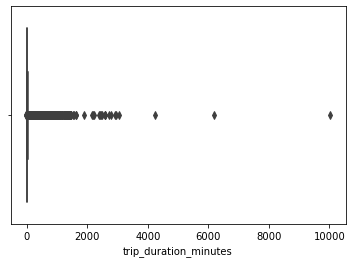

In [13]:
sns.boxplot(df["trip_duration_minutes"])

<AxesSubplot:xlabel='trip_duration_minutes', ylabel='Density'>

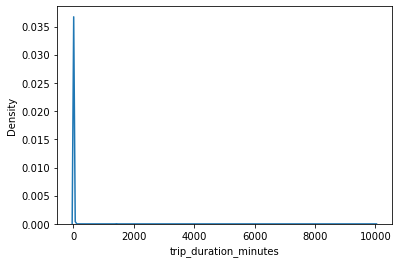

In [14]:
sns.kdeplot(data=df, x="trip_duration_minutes")

As we can see, there are some outliers with trips that are very long (10 000 minutes maximum, which would correspond to a 7 days trip). We can examine the percentiles of the data.

In [15]:
df["trip_duration_minutes"].describe(percentiles=[0.95,0.98,0.99])

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
50%      1.151667e+01
95%      3.646667e+01
98%      4.873333e+01
99%      5.725000e+01
max      1.002918e+04
Name: trip_duration_minutes, dtype: float64

We see that the 95% percentile of the trips is equal to 36 minutes, 98% is equel to 48 minutes and 99% is equal to 57 minutes. Thanks to the percentiles examination, we know that the majority of our duration trips should be under 1 hour. Everything above 1h can thus be considered as an outlier.

We can focus on trips that have a duration between 1 minute and 1 hour. Let's see the percentage of records we keep when filtering the data like this:

In [16]:
percentage_records_kept  = ((df["trip_duration_minutes"] >= 1) & (df["trip_duration_minutes"] <= 60)).mean()*100
print(f"We keep {round(percentage_records_kept,2)}% of the original records from January 2023 when keeping the trips that are over 1 minute and less than one hour.")

We keep 98.12% of the original records from January 2023 when keeping the trips that are over 1 minute and less than one hour.


We keep these records for our final dataset.

In [17]:
df = df[(df["trip_duration_minutes"] >= 1) & (df["trip_duration_minutes"] <= 60)]

In [18]:
df.shape

(3009173, 21)

In [19]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,trip_duration_minutes
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50,10.833333


In [20]:
df["trip_duration_minutes"].describe()

count    3.009173e+06
mean     1.420486e+01
std      9.939386e+00
min      1.000000e+00
25%      7.216667e+00
50%      1.155000e+01
75%      1.818333e+01
max      6.000000e+01
Name: trip_duration_minutes, dtype: float64

## Feature selection

We can distinguish between the categorical variables we want to keep and the numerical variables. For example, we first focus on the PULocationID (pick up location ID) and the DOLocationID (dropoff location ID) that are two categorical variables (IDs) for a first iteration.

In [21]:
categorical = ["PULocationID", "DOLocationID"]

## One hot encoding of categorical variables

In [22]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

Since the two categorical columns are considered as integers that are stocked in the same column, we need to one hot encode the two columns to clearly distinguish between each pickup and dropoff location ID for each trip.

To do that, we use DictVectorizer that takes a string column as input. We first need to convert the two columns into string type.

In [23]:
df[categorical] = df[categorical].astype(str)

In [24]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

The DictVectorizer also takes as input a Dictionary and create a vector from it. We need to convert our dataframe to a dict.

In [25]:
final_df = df[categorical]

In [26]:
final_df.dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [27]:
final_df.head()

,PULocationID,DOLocationID
0,161,141
1,43,237
2,48,238
3,138,7
4,107,79


In [28]:
# Quick check to see the result
final_df.to_dict(orient='records')

[{'PULocationID': '161', 'DOLocationID': '141'},
 {'PULocationID': '43', 'DOLocationID': '237'},
 {'PULocationID': '48', 'DOLocationID': '238'},
 {'PULocationID': '138', 'DOLocationID': '7'},
 {'PULocationID': '107', 'DOLocationID': '79'},
 {'PULocationID': '161', 'DOLocationID': '137'},
 {'PULocationID': '239', 'DOLocationID': '143'},
 {'PULocationID': '142', 'DOLocationID': '200'},
 {'PULocationID': '164', 'DOLocationID': '236'},
 {'PULocationID': '141', 'DOLocationID': '107'},
 {'PULocationID': '234', 'DOLocationID': '68'},
 {'PULocationID': '79', 'DOLocationID': '264'},
 {'PULocationID': '164', 'DOLocationID': '143'},
 {'PULocationID': '138', 'DOLocationID': '33'},
 {'PULocationID': '33', 'DOLocationID': '61'},
 {'PULocationID': '79', 'DOLocationID': '186'},
 {'PULocationID': '90', 'DOLocationID': '48'},
 {'PULocationID': '113', 'DOLocationID': '255'},
 {'PULocationID': '237', 'DOLocationID': '239'},
 {'PULocationID': '143', 'DOLocationID': '229'},
 {'PULocationID': '137', 'DOLocat

In [29]:
train_dicts = final_df.to_dict(orient='records')

In [30]:
# Initialize the dict vectorizer
dv = DictVectorizer()

In [31]:
# Produce our X_train dataset, the feature matrix we will use to train our model
X_train = dv.fit_transform(train_dicts)

In [32]:
X_train

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

After one hot encoding of our two variables, we obtain 515 columns in our feature dataset.

## Selection of target values

In [33]:
y_train = df["trip_duration_minutes"]

In [34]:
y_train

0           8.433333
1           6.316667
2          12.750000
3           9.616667
4          10.833333
             ...    
3066761    13.983333
3066762    19.450000
3066763    24.516667
3066764    13.000000
3066765    14.400000
Name: trip_duration_minutes, Length: 3009173, dtype: float64

# Train a linear regression model

By using our X_train and y_train, we can train a linear regression model to predict trip duration time in minutes only from pickup and dropoff locations IDs.

In [35]:
lr = LinearRegression()

In [38]:
lr.fit(X_train, y_train)

LinearRegression()

In [39]:
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


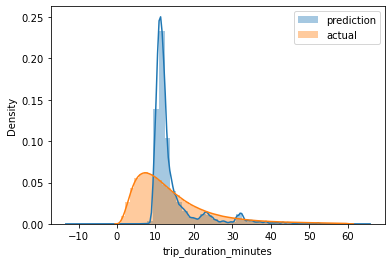

In [40]:
# Plot the prediction and the actual values for training dataset
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")
plt.legend()

We can see that the predicted values are not really similar to the actual values of duration time. We can go further and explore the related prediction metrics.

In [41]:
mean_squared_error(y_pred, y_train, squared=False)

7.6492610279057605

Our model is wrong, on average, by almost 8 minutes (RMSE=7.64).

# Use a training and a validation dataset to check our model performance

We can use the data from February 2023 as a validation dataset to see how our model trained on January 2023 performs to predict trip duration in minutes for this month.
For that, we will use the function built from the above steps.

In [3]:
df_train = read_nyc_taxi_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")
df_val = read_nyc_taxi_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")

We prepare the categorical columns we want to keep to produce our training dataset. We will use the same DictVectorizer for the validation dataset.

In [4]:
# Training dataset
categorical = ["PULocationID", "DOLocationID"]
df_train[categorical] = df_train[categorical].astype(str)
final_df_train = df_train[categorical]
train_dicts = final_df_train.to_dict(orient='records')
dv=DictVectorizer()
X_train = dv.fit_transform(train_dicts)
y_train = df_train["trip_duration_minutes"]

In [5]:
# Validation dataset
df_val[categorical] = df_val[categorical].astype(str)
final_df_val = df_val[categorical]
val_dicts = final_df_val.to_dict(orient='records')

In [6]:
# For the validation dataset, we use the already fitted DictVectorizer on the training dataset
X_val = dv.transform(val_dicts)
y_val = df_val["trip_duration_minutes"]

In [7]:
# Model training on X_train and prediction on X_val
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

In [8]:
mean_squared_error(y_val, y_pred, squared=False)

7.81183265470218

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


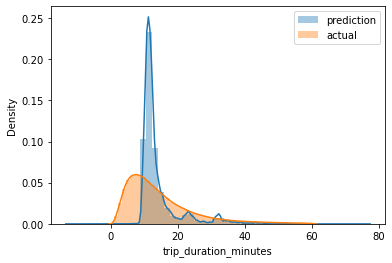

In [9]:
# Plot the prediction and the actual values for validation dataset
sns.distplot(y_pred, label="prediction")
sns.distplot(y_val, label="actual")
plt.legend()

The prediction metric RMSE is similar to the one calculated only for the training dataset, with almost 8 minutes of difference between actual and predicted values. Predicted values are also very concentrated around 10 minutes while actual values are more dispersed.